In [79]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import networkx as nx

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.gridspec as gridspec
from scipy.cluster import hierarchy

import matplotlib as mpl
mpl.style.use('seaborn')
%matplotlib inline

# Loader


In [41]:
#get users and mentions from the download files:
tweets_datas_path = ["candidatos_alcaldia_0.json"]
tw_id=[]
tw_user_id=[]
tw_user=[]
tw_text=[]
entities_long=[]
mentioned_ids=[]
tw_device=[]# print(twits[rnd_ind]["source"])
tw_date=[]# print(twits[rnd_ind]["created_at"])


for json_file in tweets_datas_path:
    with open(json_file, "r") as tweets_file:
        for line in tweets_file:
            try:
                tweet = json.loads(line)
                tw_entities=[]
                tw_entities.extend(tweet["entities"]["user_mentions"])
                entities_long.extend(tweet["entities"]["user_mentions"])
                tw_text_loop=[tweet["text"]]
                if tweet["truncated"]:#=="True": # Truncated indica si el tweet es corto o largo; si truncado, busca extendido
                    tw_text_loop=[tweet["extended_tweet"]["full_text"]]
                    tw_entities.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                    entities_long.extend(tweet["extended_tweet"]["entities"]["user_mentions"])
                else:
                    if tweet["text"][0:2]=="RT":
                        if tweet["retweeted_status"]["truncated"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["extended_tweet"]["entities"]["user_mentions"])
                        else: 
                            tw_text_loop=[tweet["retweeted_status"]["text"]]
                            tw_entities.extend(tweet["retweeted_status"]["entities"]["user_mentions"])
                        if tweet["retweeted_status"]["is_quote_status"]:
                            tw_text_loop=[tweet["retweeted_status"]["extended_tweet"]["full_text"]]
                            tw_entities.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                            entities_long.extend(tweet["retweeted_status"]["quoted_status"]["entities"]["user_mentions"])
                    else:
                        tw_text_loop=[tweet["text"]]
                tw_id.append(tweet["id_str"])
                tw_user_id.append(tweet["user"]["id_str"])
                tw_user.append(tweet["user"]["screen_name"])
                mentioned_ids.append([tweet["id_str"],tweet["user"]["id_str"],list(set([ent["id_str"] for ent in tw_entities]))])
                tw_text.append([tweet["id_str"],tw_text_loop[0]])
                tw_device.append(tweet["source"])
                tw_date.append(tweet["created_at"])
            except:
                continue

In [42]:
print("Tweets identificados con código     :",len(tw_id),"\n",
      "Tweets con usuario identificado     :",len(tw_user_id),"\n",
      "Tweets con nombre de usuario        :",len(tw_user),"\n",
      "Textos de tweets recuperados        :",len(tw_text),"\n",
      "Total de Menciones en los tweets    :",len(entities_long),"\n",
      "Tweets con menciones identificadas  :",len(mentioned_ids),"\n",
      "Tweets con dispositivos registrado  :",len(tw_device),"\n",
      "Tweets con fechas registradas       :",len(tw_date),"\n"
     )

Tweets identificados con código     : 118975 
 Tweets con usuario identificado     : 118975 
 Tweets con nombre de usuario        : 118975 
 Textos de tweets recuperados        : 118975 
 Total de Menciones en los tweets    : 663279 
 Tweets con menciones identificadas  : 118975 
 Tweets con dispositivos registrado  : 118975 
 Tweets con fechas registradas       : 118975 



In [43]:
tw_text=np.array(tw_text)

## tablas de menciones


In [44]:
ments_df=pd.DataFrame([[entit["id_str"],
                        entit["screen_name"],
                        entit["name"]
                       ]for entit in entities_long],
                     columns=["id_str","screen_name","name"])

In [45]:
ments_freq=pd.crosstab(index=ments_df.screen_name, columns="count")
ments_freq=ments_freq.sort_values(by=['count'] , ascending=False)
print("Cuentas mencionadas",ments_freq.shape[0])

Cuentas mencionadas 11965


In [46]:
# Tabla de ocurrencia de menciones por tuit
id_ments=pd.crosstab(np.array([tw_mnt for tw_mntns in mentioned_ids for tw_mnt in tw_mntns[2] ]), columns="count").sort_values(ascending=False, by="count")

In [47]:
top_n=150

In [48]:
ments_ids_top=list(id_ments.index[:top_n])

In [49]:
mntns_top_ocurr=np.array([[cand in tw_mntns[2] for cand in ments_ids_top]for tw_mntns in mentioned_ids])

In [50]:
mntns_top_ocurr.shape

(118975, 150)

In [51]:
names_mnts_top=[]
for usr_id in id_ments.index[:top_n]:
    name=""
    try:
        name=ments_df[ments_df.id_str==usr_id].screen_name.iloc[0]
    except:
        name="Unknown"
#     print(usr_id, name)
    names_mnts_top.append(name)
        
#     print(usr_id,tweets_ids[tweets_ids.tw_user_id==usr_id].tw_user.iloc[0])

In [52]:
# twtxt_ids=[txt_id[0] for txt_id in tw_text] # Id del tuit con el texto
df_mntns_top_ocurr=pd.DataFrame(mntns_top_ocurr,columns=names_mnts_top, index=tw_id)

In [53]:
tweets_ids=pd.DataFrame({"tw_user_id":tw_user_id,"tw_user":tw_user}, index=tw_id)
ids_freqs=pd.crosstab(index=tweets_ids.tw_user, columns="count")
ids_freqs=ids_freqs.sort_values(by=['count'] , ascending=False)["count"]
print("twiteros:",ids_freqs.shape[0])

twiteros: 33000


row_0
<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>    72515
<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>      26748
<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>                  8879
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       8239
<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>        1800
<a href="https://www.pyphoy.com/" rel="nofollow">Pypbot</a>                               396
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       237
<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>                    48
<a href="https://paper.li" rel="nofollow">Paper.li</a>                                     17
<a href="http://www.facebook.com/twitter" rel="nofollow">Facebook</a>                      12
<a href="http://www.tweetcaster.com" rel="nofollow">Tw

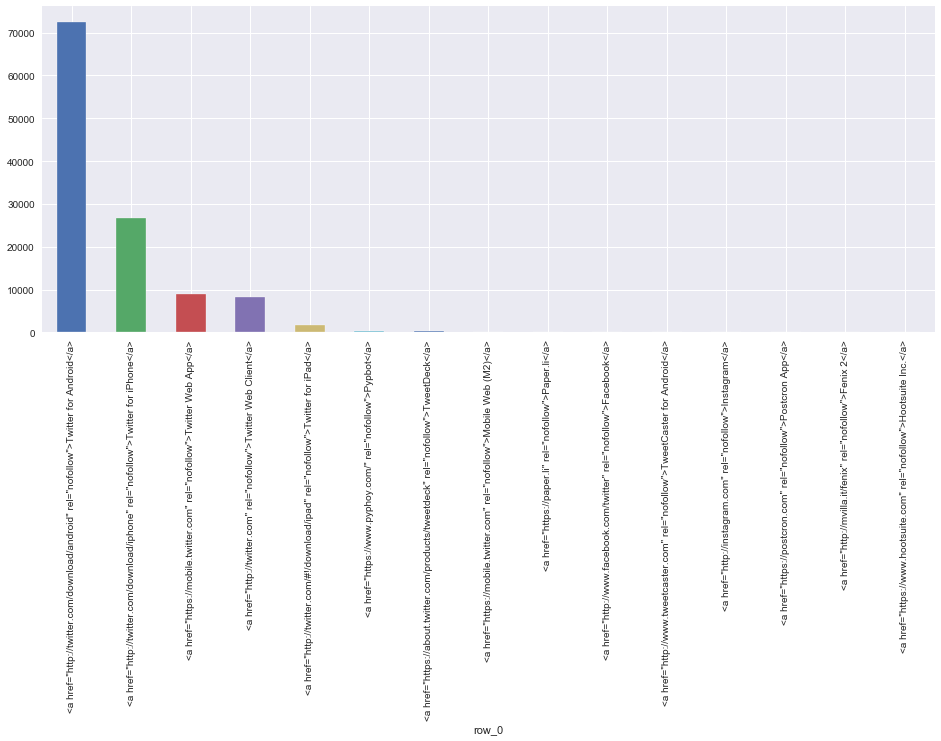

In [54]:
devices=pd.crosstab(index=np.array(tw_device), columns="count")
devices=devices.sort_values(by=['count'] , ascending=False)["count"]
devices[:15].plot(figsize=(16, 6), kind="bar")
devices[:15]

C:\Users\Alexis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


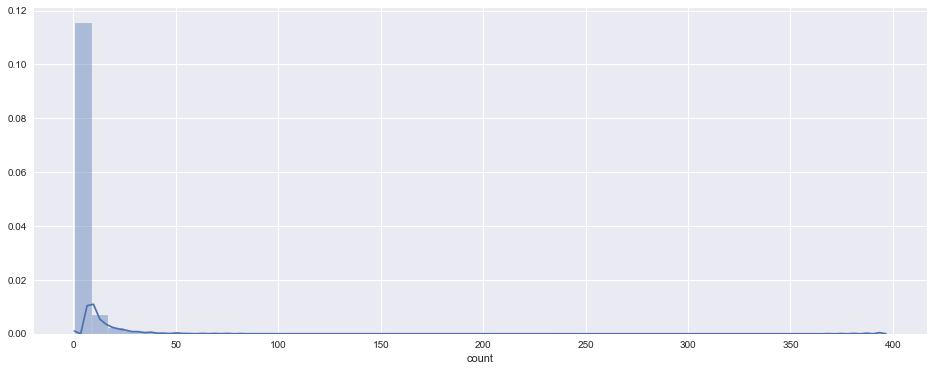

In [55]:
plt.figure(figsize=(16,6))
sns.distplot(ids_freqs)

In [56]:
round(ids_freqs.describe(),3)

count    33000.000
mean         3.605
std          7.639
min          1.000
25%          1.000
50%          1.000
75%          3.000
max        396.000
Name: count, dtype: float64

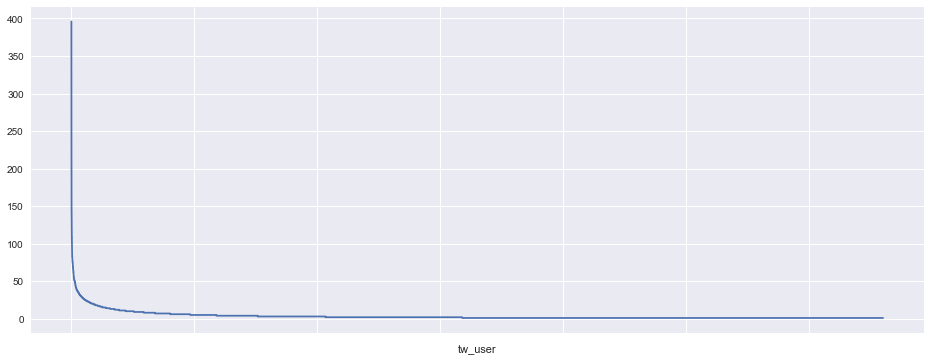

In [57]:
ids_freqs.plot(figsize=(16, 6))

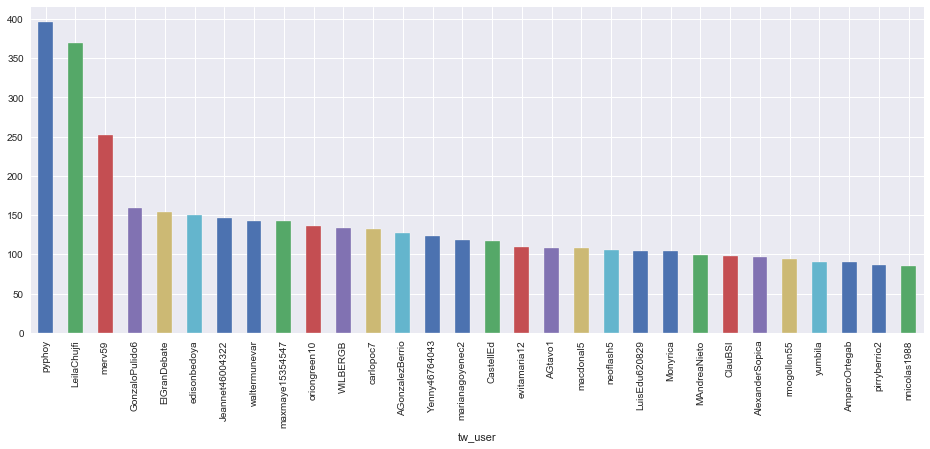

In [58]:
ids_freqs[:30].plot(figsize=(16, 6), kind="bar")
plt.savefig('top_tweeters.png')

In [59]:
ids_freqs.sort_values(ascending=False)[:60]

tw_user
pyphoy             396
LeilaChujfi        370
merv59             252
GonzaloPulido6     159
ElGranDebate       154
edisonbedoya       150
Jeannet46004322    146
waltermunevar      143
maxmaye15354547    143
oriongreen10       136
WILBERGB           134
carlopoc7          132
AGonzalezBerrio    127
Yenny46764043      124
marianagoyenec2    118
CastellEd          117
evitamaria12       109
macdonal5          108
AGtavo1            108
neoflash5          105
LuisEdu620829      104
Monyrica           104
MAndreaNieto        99
ClauBSI             98
AlexanderSopica     96
rmogollon55         94
AmparoOrtegab       90
yumbila             90
pirryberrio2        87
nnicolas1988        85
lusecitagomes       84
marco_caldono       84
martik1214          84
Yourmung            83
Martharoga          82
cignahoy            81
WILSONRUIZRUIZ1     81
CHATEAUBRIAND15     81
Lucas89777309       80
helmanzano          80
Efrenarenas3        78
Lucecita1231        77
h3rrrrrr            77
wil

In [60]:
uniq_ids=list(set([entit["id_str"]for entit in entities_long]))
len(uniq_ids)

11952

ClaudiaLopez       63036
angelamrobledo     24621
MiguelUribeT       17801
petrogustavo       14665
CConstitucional    12685
HOLLMANMORRIS       9242
IvanDuque           8384
GustavoBolivar      7337
EnriquePenalosa     4764
angelagarzonc       4578
saludhernandezm     4326
carlosfgalan        4012
AidaAvellaE         4005
VickyDavilaH        3617
CarlosCarrilloA     3229
merv59              3221
PartidoVerdeCoL     3198
AngelicaLozanoC     3166
jerojasrodrigue     3001
IvanCepedaCast      2962
dtype: int64


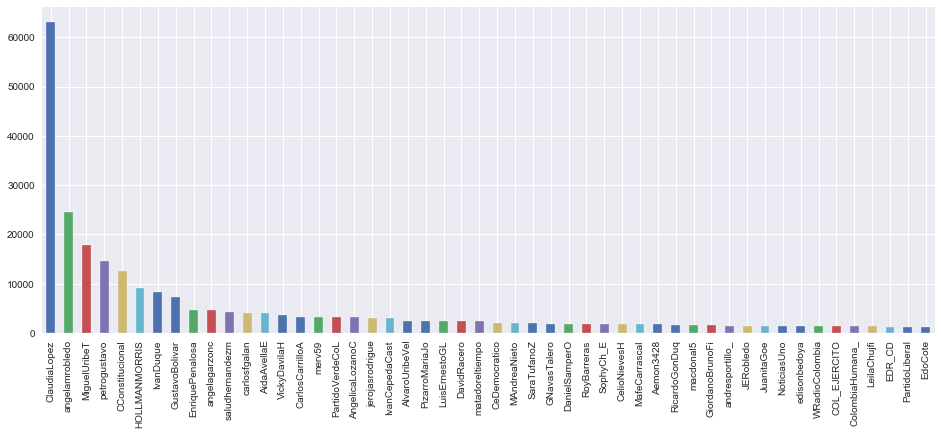

In [61]:
plt.figure(figsize=(16,6))
print (df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:20])
df_mntns_top_ocurr.sum(axis=0).sort_values(ascending=False)[:50].plot(kind="bar")
plt.savefig('top_mentions.png')

# Relaciones de cuentas

In [62]:
directed_graph_df=df_mntns_top_ocurr.groupby(tw_user).aggregate(sum)

# Temporalidad

In [63]:
tw_fechas_df=pd.DataFrame(np.column_stack([tw_user,tw_date]))
tw_fechas_df.columns=["user","date_tweet"]
tw_fechas_df["date_tweet"]=pd.to_datetime(tw_fechas_df['date_tweet'], utc=True)#.tz_convert('US/Eastern')
tw_fechas_df.set_index('date_tweet', inplace=True)#.tz_convert('US/Eastern')
tw_fechas_df.index=tw_fechas_df.index.tz_convert('Etc/GMT+5')
tw_fechas_df["ocurr"]=1

In [64]:
time_sample="900S"#"3600s"#'1440T'

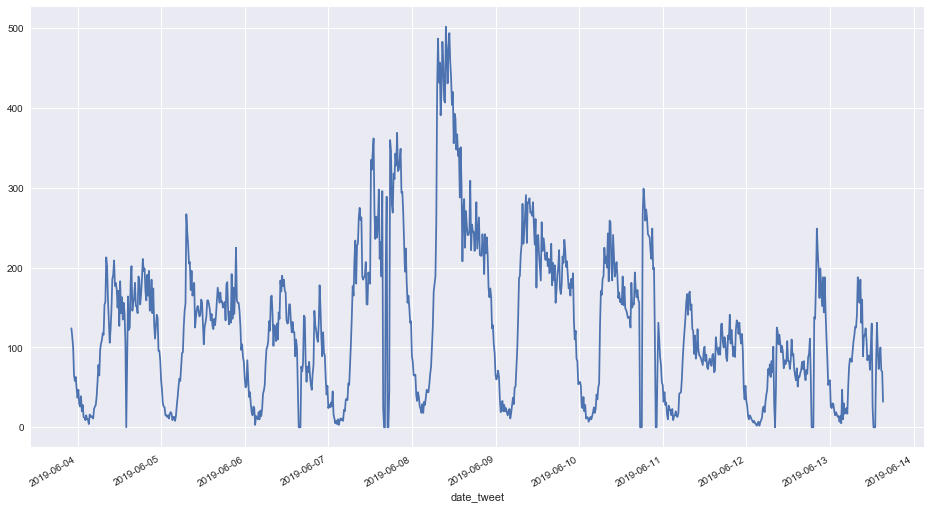

In [65]:
plt.figure(figsize=(16,9))
tw_fechas_df.ocurr.resample(time_sample).sum().plot()#kind="bar")

In [66]:
mayor_tweeters=list(directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:10])

In [67]:
tw_fechas_df_top=tw_fechas_df[tw_fechas_df.user.isin(mayor_tweeters)]
#tw_fechas_df_filt.head(20)

In [68]:
twits_filt=pd.crosstab(index=tw_fechas_df_top.index,
                  columns=tw_fechas_df_top["user"])
twits_filt=twits_filt.resample(time_sample).sum()

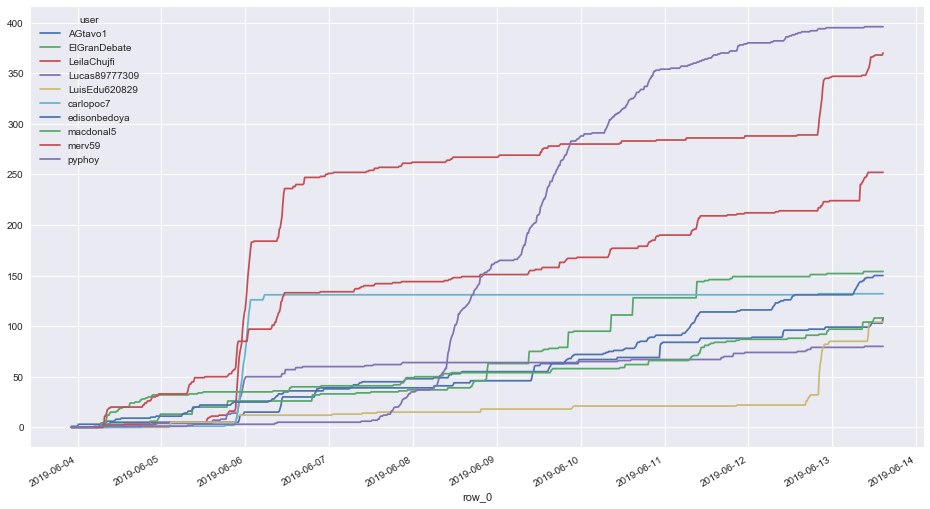

In [69]:
twits_filt.cumsum().plot(figsize=(16,9))

In [70]:
top_ments_df=df_mntns_top_ocurr.copy()*1
top_ments_df.index=tw_fechas_df.index
# top_ments_df.head(20)

In [71]:
top_ments_df_day=top_ments_df.iloc[:,:10].resample(time_sample).sum()

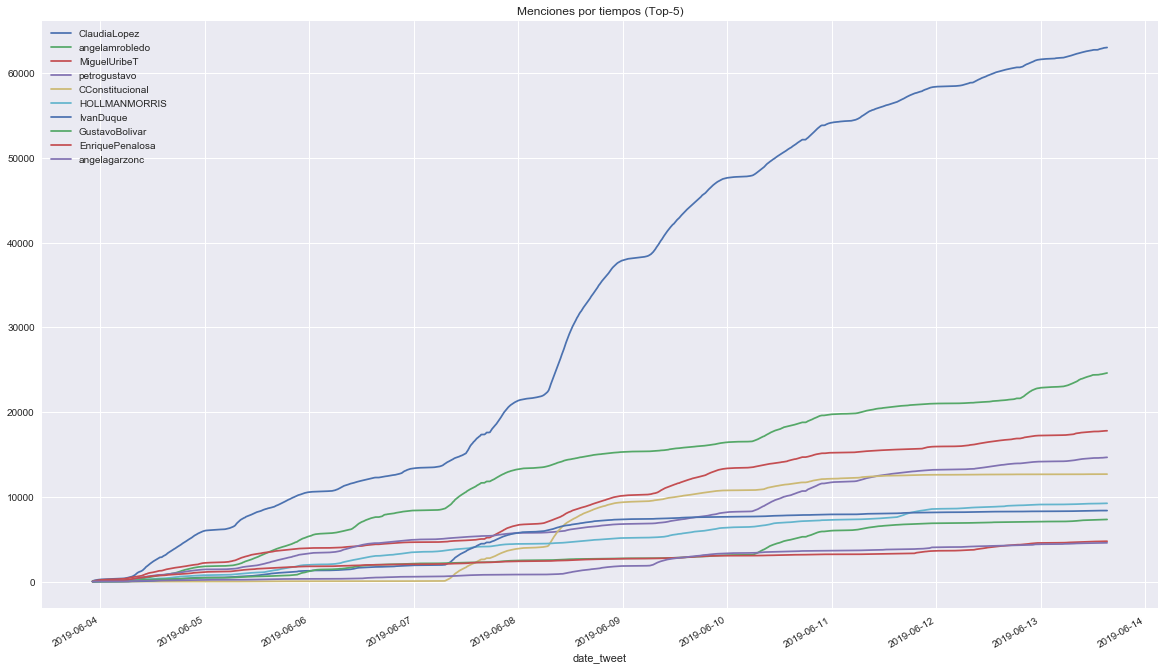

In [72]:
top_ments_df_day.cumsum().plot(figsize=(20,12), title="Menciones por tiempos (Top-5)")

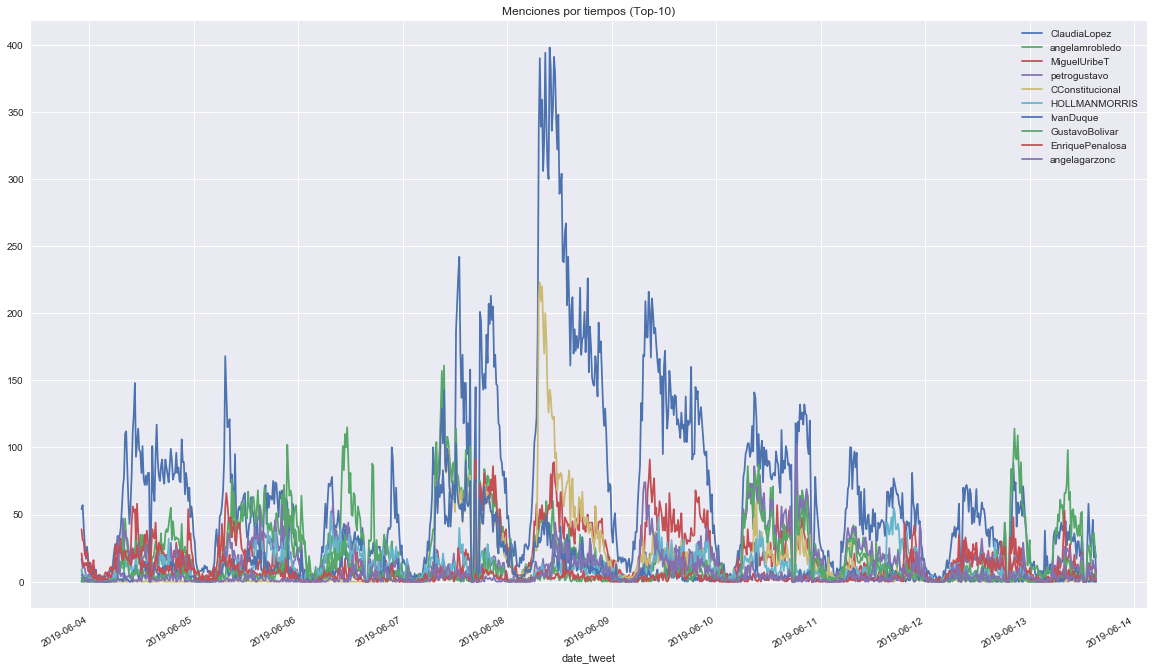

In [73]:
top_ments_df_day.plot(figsize=(20,12), title="Menciones por tiempos (Top-10)")

# Grafos

In [74]:
mat_size=40
graph_mat=directed_graph_df.loc[directed_graph_df.sum(axis=1).sort_values(ascending=False).index[:mat_size],
                                directed_graph_df.sum(axis=0).sort_values(ascending=False).index[:mat_size]
                               ]
graph_mat.head()

,ClaudiaLopez,angelamrobledo,MiguelUribeT,petrogustavo,CConstitucional,HOLLMANMORRIS,IvanDuque,GustavoBolivar,EnriquePenalosa,angelagarzonc,...,RoyBarreras,SophyCh_E,CelioNievesH,MafeCarrascal,Aemon3428,RicardoGonDuq,macdonal5,GiordanoBrunoFi,andresportillo_,JERobledo
LeilaChujfi,19.0,337.0,8.0,25.0,0.0,4.0,58.0,253.0,1.0,0.0,...,5.0,0.0,0.0,3.0,236.0,0.0,3.0,236.0,0.0,3.0
merv59,19.0,207.0,3.0,121.0,0.0,5.0,25.0,174.0,1.0,1.0,...,3.0,0.0,1.0,10.0,66.0,0.0,106.0,65.0,0.0,8.0
carlopoc7,0.0,129.0,0.0,2.0,0.0,2.0,0.0,128.0,0.0,0.0,...,0.0,0.0,0.0,0.0,128.0,0.0,0.0,128.0,0.0,0.0
edisonbedoya,1.0,150.0,0.0,145.0,0.0,0.0,10.0,143.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,124.0,0.0,0.0,0.0
Lucas89777309,3.0,69.0,0.0,15.0,0.0,13.0,15.0,55.0,1.0,0.0,...,1.0,0.0,0.0,0.0,58.0,0.0,5.0,52.0,0.0,0.0


In [75]:
graph_df=graph_mat.melt()
graph_df.columns=["tw_para", "freq"]
graph_df["tw_de"]=[usr for i in range(int(len(graph_df)/len(graph_mat.index)))for usr in list(graph_mat.index)]
graph_df=graph_df.loc[:,["tw_de","tw_para","freq"]]

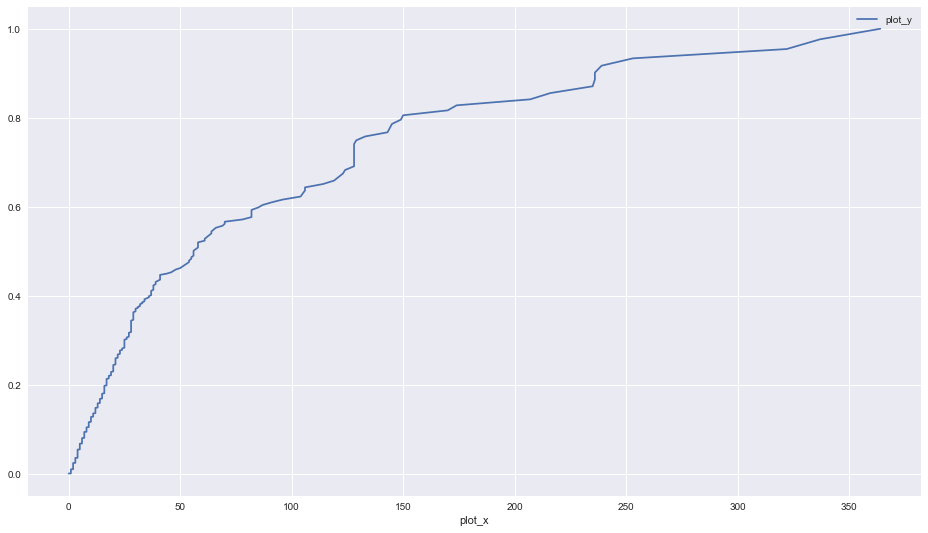

In [76]:
plot_x=np.array(list(graph_df.freq.sort_values(ascending=True)))
plot_y=np.cumsum(plot_x)/sum(plot_x)
cum_freq=pd.DataFrame({"plot_x":plot_x,
                       "plot_y":plot_y})
cum_freq.plot(x="plot_x",
              y="plot_y",
             figsize=(16,9))

In [97]:
min_crit_tw=cum_freq[cum_freq.plot_y>=.3].iloc[0,0]
graph_df_filt=graph_df.loc[graph_df.freq>=min_crit_tw,:]
mx_fr=max(graph_df_filt.freq)
print(min_crit_tw)
print(len(graph_df_filt))
graph_df_filt.sort_values("freq",ascending=False)#.head(20)

25.0
158


,tw_de,tw_para,freq
6,pyphoy,ClaudiaLopez,364.0
40,LeilaChujfi,angelamrobledo,337.0
600,LeilaChujfi,merv59,322.0
280,LeilaChujfi,GustavoBolivar,253.0
480,LeilaChujfi,AidaAvellaE,239.0
1480,LeilaChujfi,GiordanoBrunoFi,236.0
1360,LeilaChujfi,Aemon3428,236.0
1080,LeilaChujfi,SaraTufanoZ,235.0
601,merv59,merv59,216.0
41,merv59,angelamrobledo,207.0


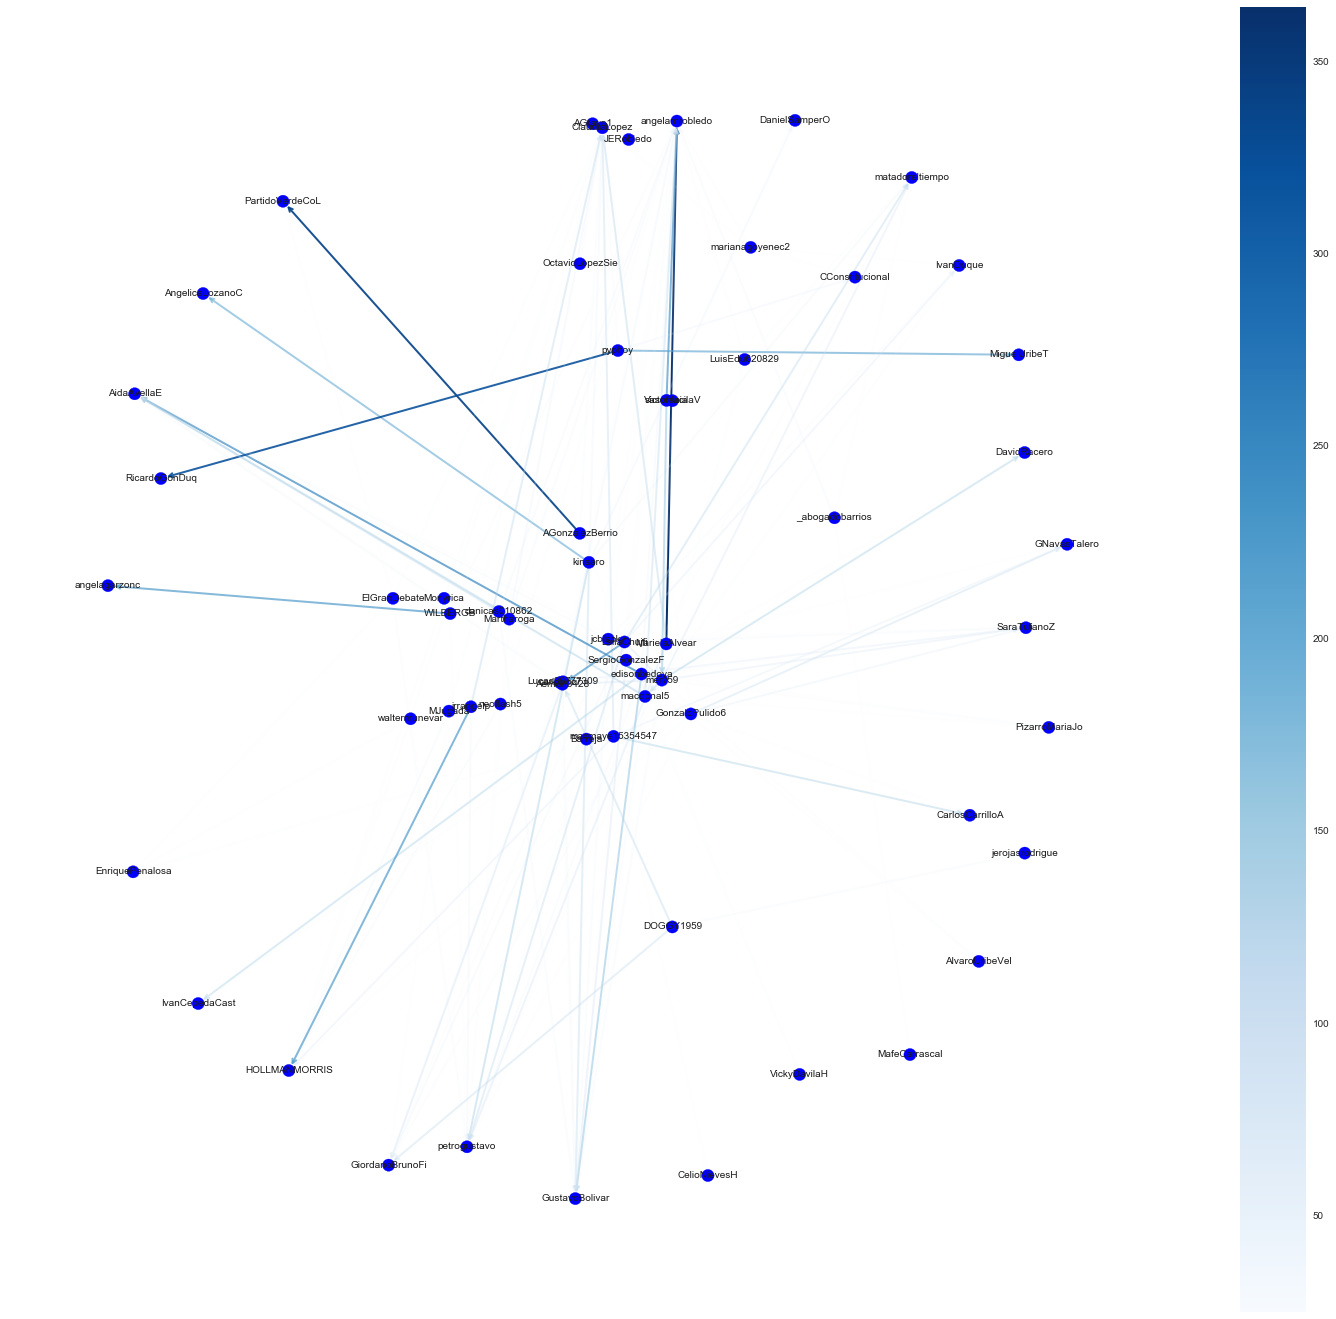

In [98]:
plt.figure(figsize=(26,24))
G= nx.DiGraph()#nx.generators.directed.random_k_out_graph(10, 3, 0.5)
for i, elrow in graph_df_filt.iterrows():
    G.add_edge(elrow[0], elrow[1])

pos = nx.layout.spring_layout(G)

node_sizes = [150 for i in range(len(G))]
M = G.number_of_edges()
edge_colors =[fr for fr in graph_df_filt.freq]#range(2, M + 2)
edge_alphas =[fr/mx_fr for fr in graph_df_filt.freq]#[fr/mx_fr for fr in graph_df_filt.freq]#[(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=10, edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues, width=2)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

nx.draw_networkx_labels(G, pos, font_size=10)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [99]:
g = nx.Graph()

In [100]:
for i, elrow in graph_df_filt.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [101]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 156
# of nodes: 62


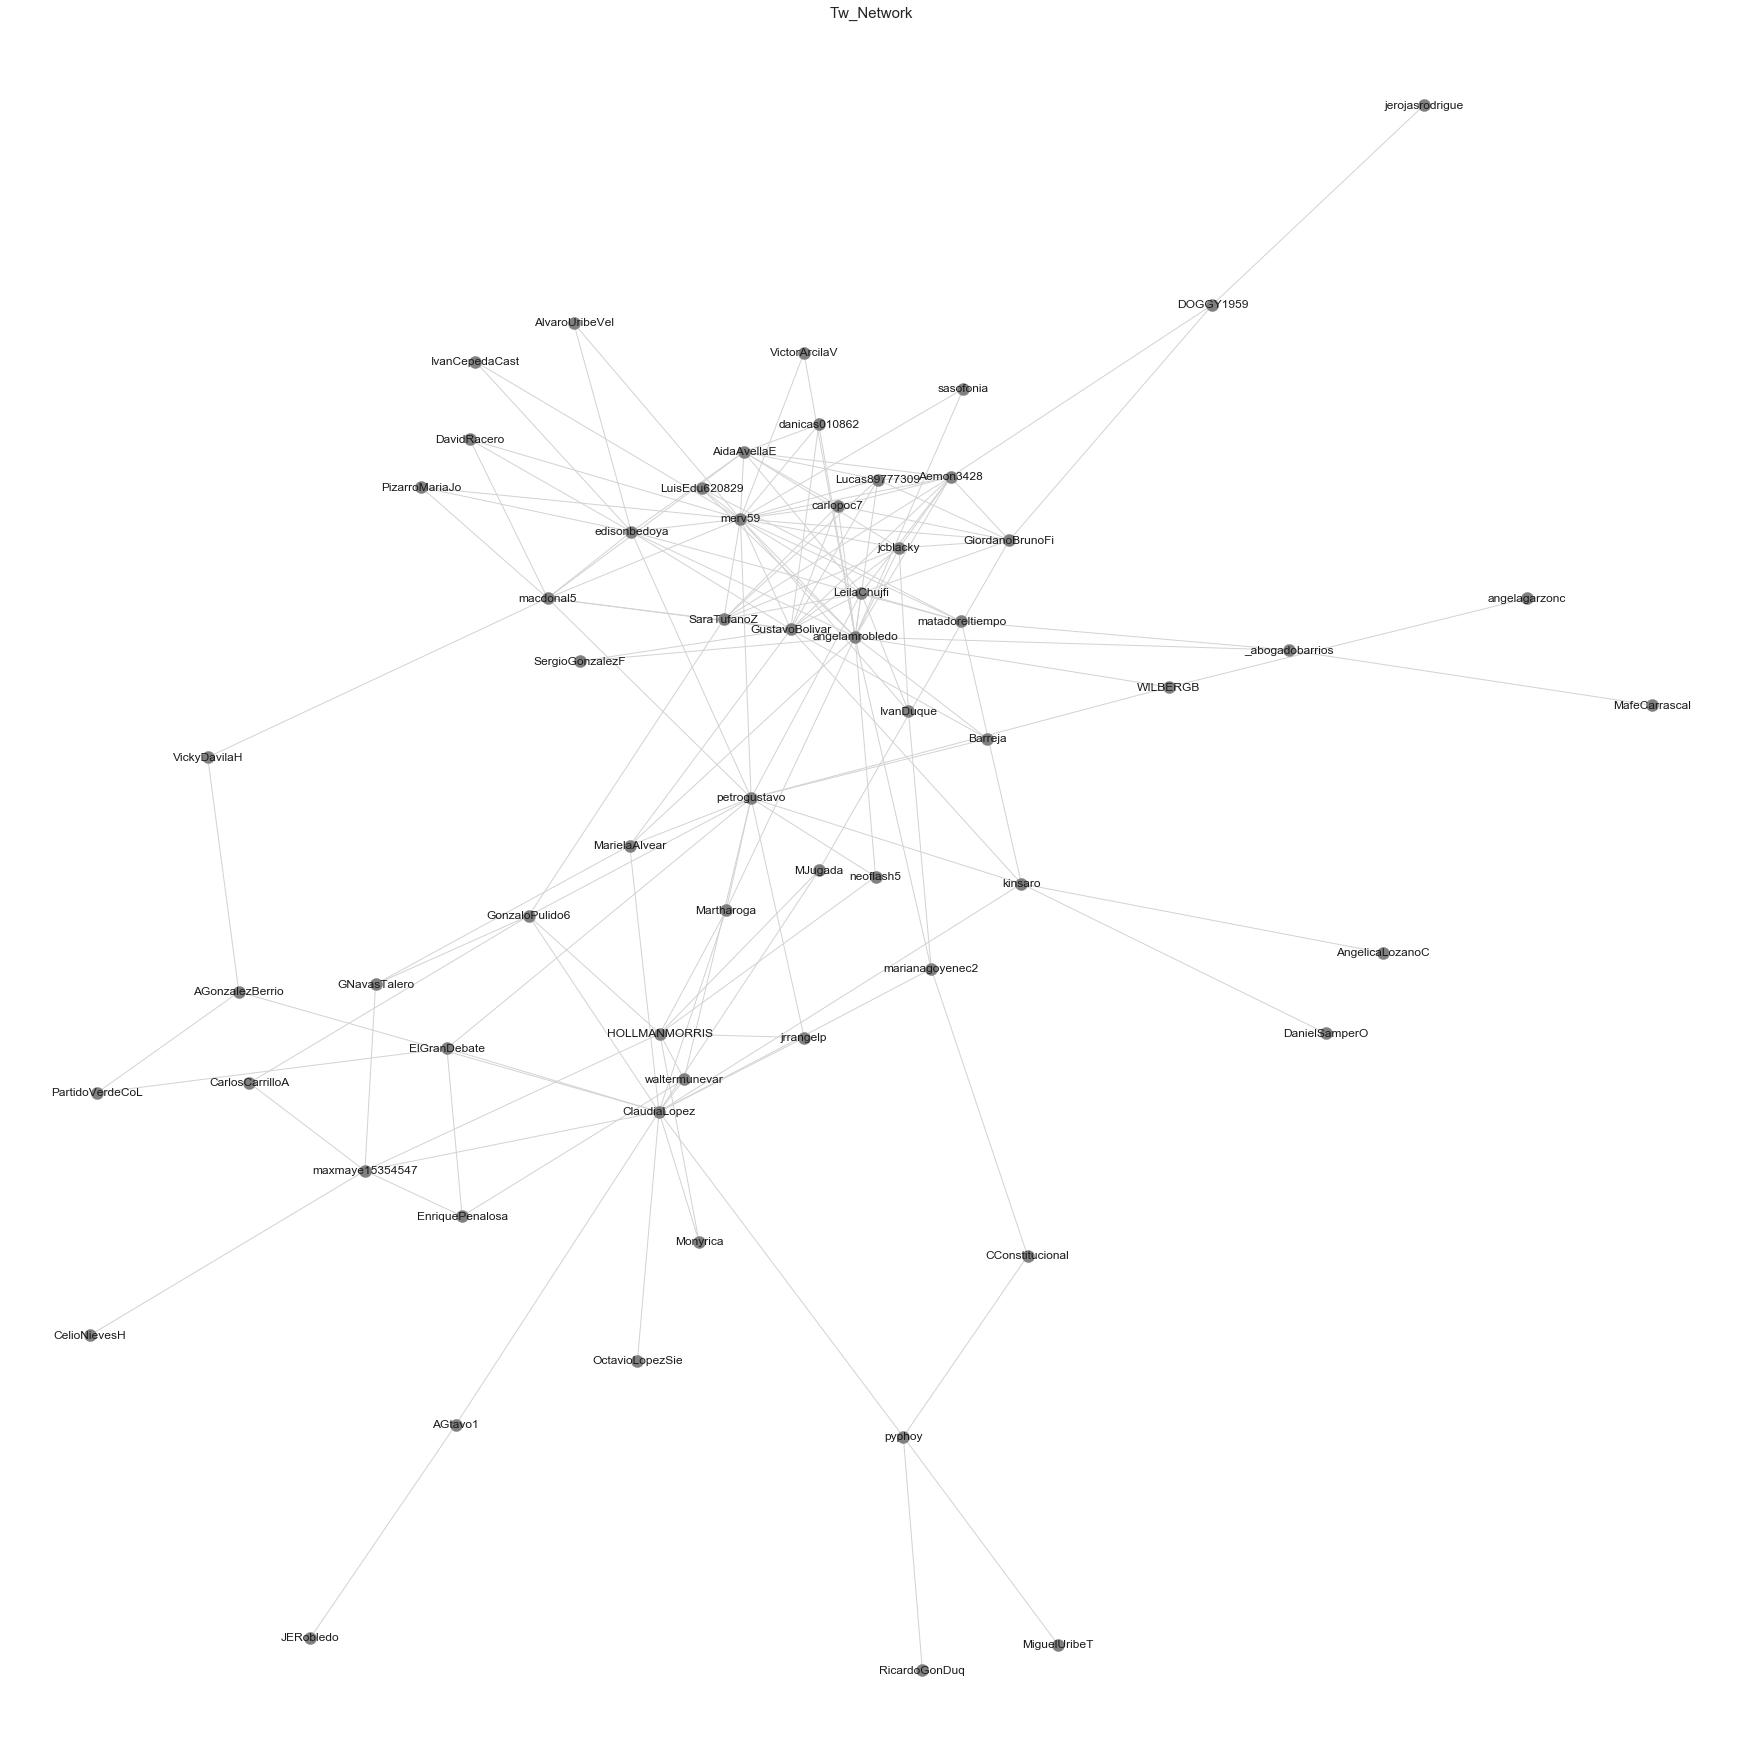

In [102]:
plt.figure(figsize=(24, 24))
nx.draw(g,
        node_size=150,
        edge_color='lightgray',
        node_color='gray',
        with_labels=True)
plt.title('Tw_Network', size=15)
plt.show()
# plt.savefig('tweets_net.png')